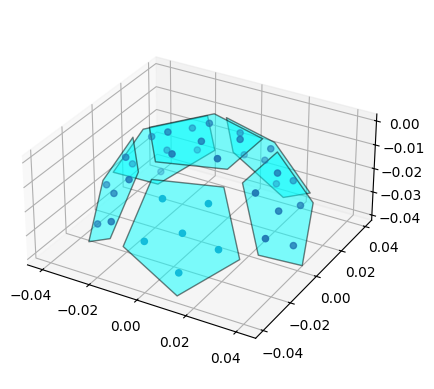

100%|██████████| 384000/384000 [26:51<00:00, 238.33it/s]


In [1]:
from dynamic_sound import Simulation, get_sinewave, HedraPhone_v2, get_white_noise
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# simulation parameters
sample_rate = 48_000
sim = Simulation(sample_rate=sample_rate, time_start=0.0, time_duration=8.0)
sim.set_environment(temperature=20, pressure=1, relative_humidity=50)

# microphones
sim.add_microphones(microphones=HedraPhone_v2.get_microphones(), path=(
    (0.0, (0, 0, 1.0)),
    (8.0, (0, 0, 1.0))
))
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

custom_array_microphones = HedraPhone_v2.get_microphones().T

ax.scatter(custom_array_microphones[0], custom_array_microphones[1], custom_array_microphones[2], marker='o')
for pcb in HedraPhone_v2.pcb:
    ax.add_collection3d(Poly3DCollection([pcb.faces.T], alpha=0.5, facecolor='cyan', edgecolor='k'))
ax.set_aspect('equal')
plt.show()

# sound source
#samples = get_sinewave(frequency=2_000, duration=10, sample_rate=sample_rate)
samples = get_white_noise(duration=10, sample_rate=sample_rate)
sim.add_source(samples=samples, path=(
    (0.0, (3, 20, 1)),
    (8.0, (3, -20, 1))
))

# # image source
sim.add_source(samples=samples, path=(
    (0.0, (3, 20, -1)),
    (8.0, (3, -20, -1))
))

# run simulation
sim.run(output_filename="_tmp/output_white.wav")

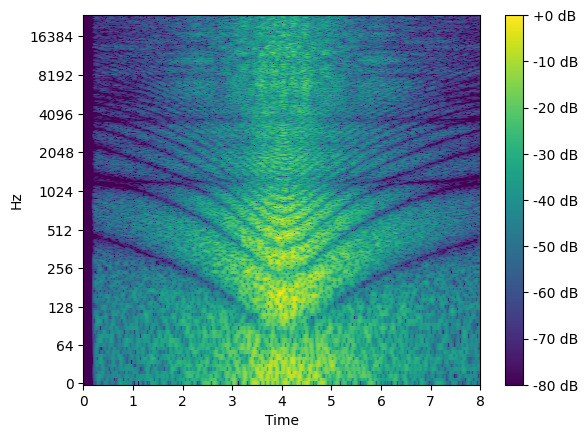

In [17]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np

samples_out, sample_rate = librosa.load("_tmp/output_white.wav", sr=None, mono=True)

ipd.display(ipd.Audio(samples_out, rate=sample_rate))

n_fft=1024*8
hop_length = 512//8
D = librosa.amplitude_to_db(np.abs(librosa.stft(samples_out, n_fft=n_fft, hop_length=hop_length)), ref=np.max)
img = librosa.display.specshow(D, y_axis='log',
                               sr=sample_rate,
                               n_fft=n_fft,
                               hop_length=hop_length,
                               x_axis='time',
                               cmap='viridis',
                               #clim=(-50, 0)
                               )
plt.colorbar(format="%+2.f dB")
plt.show()

(36, 384000)
freq range [11428.57142857143, 11428.57142857143]


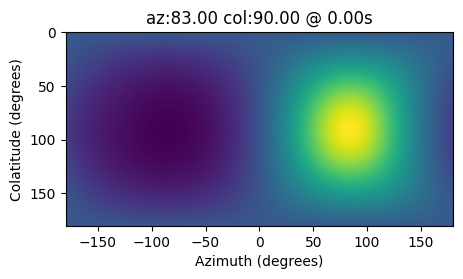

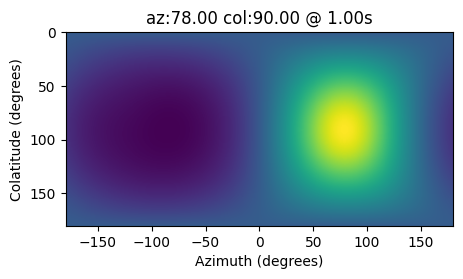

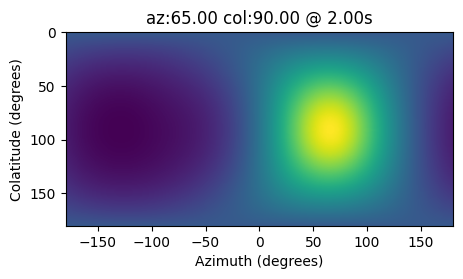

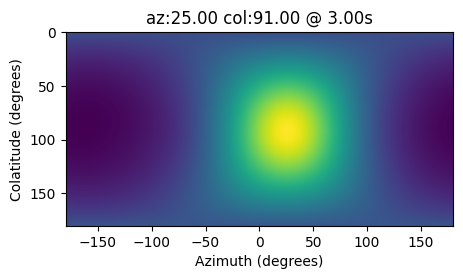

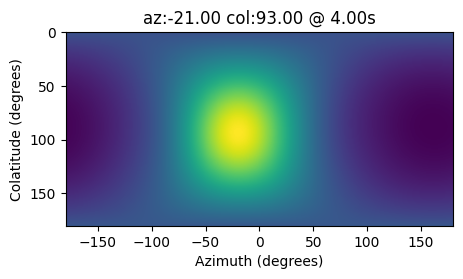

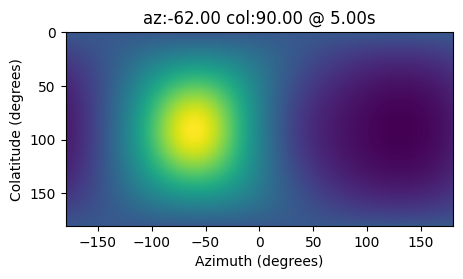

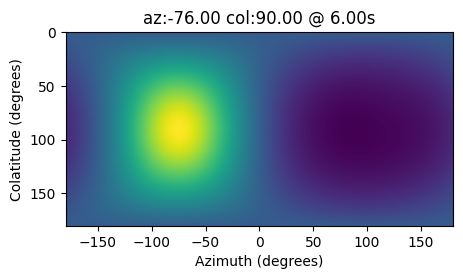

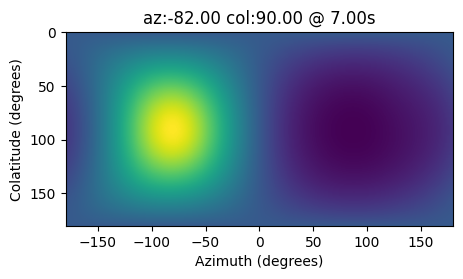

In [14]:
import pyroomacoustics as pra
from dynamic_sound import HedraPhone_v2

samples_out, sr = librosa.load("_tmp/output_white.wav", sr=None, mono=False)
print(samples_out.shape)

c = 343.0  # speed of sound
nfft = 126 #256  # FFT size

freq_bins = range(30,31)
freq_range = [(min(freq_bins)*sr)/nfft, (max(freq_bins)*sr)/nfft]  # FFT bins to use for estimation
print(f"freq range {freq_range}")

resolution_step = 1  # degrees
algo = pra.doa.normmusic.NormMUSIC(L=HedraPhone_v2.get_microphones().T, c=c, fs=sr, nfft=nfft,
                                azimuth=np.deg2rad(np.arange(-180, 180, resolution_step)),
                                colatitude=np.deg2rad(np.arange(0, 180, resolution_step)),
                                dim=3, mode='near')

for sample_index in range(0, len(samples_out[0]), len(samples_out[0])//8):

    X = np.array(
        [pra.transform.stft.analysis(signal, nfft, nfft // 2).T for signal in samples_out[:, sample_index:sample_index+sr]]
    )
    algo.locate_sources(X)#, freq_bins=freq_bins)

    spatial_resp = algo.grid.values
    min_val = spatial_resp.min()
    max_val = spatial_resp.max()
    spatial_resp = (spatial_resp - min_val) / (max_val - min_val)

    plt.figure(figsize=(5, 5))
    plt.title(f"az:{np.rad2deg(algo.azimuth_recon[0]):.2f} col:{np.rad2deg(algo.colatitude_recon[0]):.2f} @ {sample_index/sr:.2f}s")
    plt.imshow(spatial_resp.reshape((-1, 360//resolution_step)), aspect=1, extent=[-180, 180, 180, 0])
    plt.xlabel("Azimuth (degrees)")
    plt.ylabel("Colatitude (degrees)")
    plt.show()